<a href="https://colab.research.google.com/github/p33ves/CMPT726-ML-Project/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machine(SVM) Model

In [ ]:
import pandas as pd
import numpy as np
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# !pip install plotly==4.12.0
import plotly.express as px

Loading dataset from Github repo

In [ ]:
full_dataset_url = "https://raw.githubusercontent.com/p33ves/CMPT726-ML-Project/main/processed_datasets/xtr_profile.csv"
data = pd.read_csv(full_dataset_url)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   gender                              14825 non-null  object 
 1   age                                 14825 non-null  int64  
 2   cust_id                             14825 non-null  object 
 3   became_member_on                    14825 non-null  object 
 4   income                              14825 non-null  float64
 5   days_as_member                      14825 non-null  int64  
 6   Total offer completed               14825 non-null  float64
 7   Total offer received                14825 non-null  float64
 8   Total offer viewed                  14825 non-null  float64
 9   Total transaction                   14825 non-null  float64
 10  offer completed_via_email           14825 non-null  float64
 11  offer completed_via_social          14825

Finding categorical features and Encoding

In [ ]:
data.select_dtypes(include=[object])

,gender,cust_id,became_member_on
0,F,0610b486422d4921ae7d2bf64640c50b,2017-07-15
1,F,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09
2,M,e2127556f4f64592b11af22de27a7932,2018-04-26
3,M,389bc3fa690240e798340f5a15918d5c,2018-02-09
4,M,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11
...,...,...,...
14820,F,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04
14821,M,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13
14822,M,01d26f638c274aa0b965d24cefe3183f,2017-01-26
14823,F,9dc1421481194dcd9400aec7c9ae6366,2016-03-07


Feature engineering

In [ ]:
# define dataset
gen_split = pd.get_dummies(data['gender'], prefix='is_')
# data['income_in_k'] = data['income']/1000
data = pd.concat([data, gen_split], axis=1)
# data = data.drop('income', axis=1)
data = data.drop('is__O', axis=1)
data.drop('gender', axis=1, inplace=True)
data.sample(10)

,age,cust_id,became_member_on,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,Total transaction,offer completed_via_email,offer completed_via_social,offer completed_via_mobile,offer completed_via_web,offer completed bogo count,offer completed discount count,offer received_via_email,offer received_via_social,offer received_via_mobile,offer received_via_web,offer received bogo count,offer received discount count,offer received informational count,offer viewed_via_email,offer viewed_via_social,offer viewed_via_mobile,offer viewed_via_web,offer viewed bogo count,offer viewed discount count,offer viewed informational count,Total transaction amount,avg_difficulty,avg_duration,total_reward_received,total_reward_defined,total_view_ratio,total_completion_ratio,avg_transaction_amt,transactions_per_membership_days,is__F,is__M
3425,47,28765f822e7f477b90a226ee29bcc473,2017-06-01,43000.0,1274,4.0,5.0,3.0,13.0,4.0,3.0,3.0,3.0,1.0,3.0,5.0,3.0,4.0,4.0,1.0,4.0,0.0,3.0,3.0,3.0,2.0,1.0,2.0,0.0,131.93,10.916667,198.000000,20.0,22.0,0.60,0.800,10.15,0.010204,0,1
12250,29,787c1f76fcbb417394f951c87dc4c3d9,2016-07-17,44000.0,1593,1.0,4.0,3.0,19.0,1.0,1.0,1.0,1.0,0.0,1.0,4.0,2.0,4.0,4.0,1.0,1.0,2.0,3.0,2.0,3.0,3.0,1.0,1.0,1.0,57.50,6.250000,156.000000,2.0,12.0,0.75,0.250,3.03,0.011927,0,1
12862,59,1a80ad14c7f7425ab5445f68c7c297e6,2017-07-17,70000.0,1228,2.0,3.0,2.0,8.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,2.0,3.0,3.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,169.57,8.571429,168.000000,12.0,12.0,0.67,0.667,21.20,0.006515,0,1
6140,69,bea062a97557458a97f3e2df8d87755a,2017-02-09,99000.0,1386,3.0,5.0,4.0,11.0,3.0,3.0,3.0,3.0,1.0,2.0,5.0,4.0,5.0,4.0,1.0,2.0,2.0,4.0,4.0,4.0,3.0,1.0,2.0,1.0,286.16,6.750000,152.000000,15.0,15.0,0.80,0.600,26.01,0.007937,1,0
6838,57,9aa25ad8fd1940efb459bb515e6abcb5,2018-07-02,39000.0,878,4.0,6.0,4.0,6.0,4.0,2.0,4.0,4.0,3.0,1.0,6.0,4.0,6.0,5.0,4.0,1.0,1.0,4.0,4.0,4.0,3.0,3.0,0.0,1.0,78.51,6.785714,126.857143,22.0,32.0,0.67,0.667,13.08,0.006834,0,1
894,43,bcb0d199780640afbf378537c3e7f8d7,2018-03-24,51000.0,978,2.0,5.0,4.0,9.0,2.0,2.0,2.0,2.0,1.0,1.0,5.0,4.0,5.0,5.0,3.0,2.0,0.0,4.0,4.0,4.0,4.0,2.0,2.0,0.0,31.64,7.363636,159.272727,8.0,25.0,0.80,0.400,3.52,0.009202,0,1
6742,28,02c8c9806a8c44f792a218fb2e8756b3,2018-04-29,45000.0,942,1.0,5.0,4.0,4.0,1.0,0.0,1.0,1.0,1.0,0.0,5.0,4.0,5.0,5.0,3.0,2.0,0.0,4.0,4.0,4.0,4.0,2.0,2.0,0.0,21.93,8.000000,177.600000,5.0,24.0,0.80,0.200,5.48,0.004246,0,1
542,66,f4c75d8d43054e86993529f63ca54f00,2017-05-23,54000.0,1283,2.0,6.0,3.0,10.0,2.0,2.0,2.0,2.0,0.0,2.0,6.0,3.0,5.0,6.0,3.0,3.0,0.0,3.0,3.0,3.0,3.0,1.0,2.0,0.0,34.66,9.181818,185.454545,5.0,30.0,0.50,0.333,3.47,0.007794,0,1
2542,37,51adc00878c347ceac3fba0ca2b7b608,2015-12-25,65000.0,1798,3.0,4.0,4.0,11.0,3.0,1.0,3.0,3.0,0.0,3.0,4.0,2.0,4.0,3.0,0.0,3.0,1.0,4.0,2.0,4.0,3.0,0.0,3.0,1.0,207.47,7.363636,150.545455,7.0,7.0,1.00,0.750,18.86,0.006118,0,1
9079,49,9c5d887ee6104ac29e8474a2037e420d,2018-02-10,77000.0,1020,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0,38.60,8.200000,196.800000,3.0,5.0,1.00,0.500,19.30,0.001961,0,1


Adding label

In [ ]:
data['customer_type'] = "passive"
data.loc[(data['total_view_ratio'] >= 0.6) & (data['total_completion_ratio'] >= 0.2), 'customer_type'] = "active" 
data['customer_type'].value_counts()

active     9637
passive    5188
Name: customer_type, dtype: int64

In [ ]:
data['customer_type']

0        passive
1         active
2         active
3         active
4         active
          ...   
14820    passive
14821    passive
14822    passive
14823     active
14824    passive
Name: customer_type, Length: 14825, dtype: object

Feature / Taget Define

In [ ]:
# define dataset
X = data[[
          'is__F',
          'age',
          'income',
          'avg_difficulty', 
          'avg_duration', 
          'avg_transaction_amt', 
          'transactions_per_membership_days', 
          'days_as_member'
          ]].to_numpy()

# Encoding non-numerical labels(target) to numerical labels
y = data['customer_type']
y = y.replace(to_replace='active', value = 1)
y = y.replace(to_replace='passive', value = 0)

Which Features Were Selected?

In [ ]:
# report which features were selected by RFE
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
# # define RFE
# rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
# # fit RFE
# rfe.fit(X, y)

model = DecisionTreeClassifier()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='accuracy')
pipeline = Pipeline(steps=[('s',rfecv),('m',model)])
pipeline.fit(X, y)

# summarize all features
for i in range(X.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 4.000
Column: 1, Selected False, Rank: 3.000
Column: 2, Selected False, Rank: 2.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000


Using SVM model with selected features

In [ ]:
X = data[[
          'avg_difficulty', 
          'avg_duration', 
          'avg_transaction_amt', 
          'transactions_per_membership_days', 
          'days_as_member'
          ]].to_numpy()
          
# # Encoding non-numerical labels(target) to numerical labels
y = data['customer_type']
y = y.replace(to_replace='active', value = 0)
y = y.replace(to_replace='passive', value = 1)

In [ ]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

from imblearn.over_sampling import SMOTE

#Applying SMOTE to oversample the minority class before modeling
oversample = SMOTE(random_state = 101)
X_train, y_train = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
svm = SVC()
sc = StandardScaler()
sc.fit_transform(X_train)
svm.fit(X_train, y_train)
print('Accuracy: {}'.format(svm.score(X_test, y_test)))

Accuracy: 0.6101180438448567


In [ ]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]

# Specify the hyperparameter space
parameters = {'SVM__C':[1, 10, 100],
              'SVM__gamma':[0.1, 0.01]}

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Instantiate the GridSearchCV object: gcv
gcv = GridSearchCV(pipeline, param_grid=parameters, scoring='accuracy', cv=5, n_jobs=-1, error_score='raise')

In [ ]:
# Fit to the training set
gcv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SVM',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0

In [ ]:
# Predict the labels of the test set: y_pred
y_pred = gcv.predict(X_test)
# Compute and print metrics
print("Accuracy: {}".format(gcv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(gcv.best_params_))

# passive : 0 / active : 1

Accuracy: 0.8016863406408095
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1942
           1       0.73      0.67      0.70      1023

    accuracy                           0.80      2965
   macro avg       0.78      0.77      0.78      2965
weighted avg       0.80      0.80      0.80      2965

Tuned Model Parameters: {'SVM__C': 100, 'SVM__gamma': 0.1}


In [ ]:
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred)
print('F1 score of Model Prediction: ', f1_score)

F1 score of Model Prediction:  0.7009155645981688


[[0.869207   0.130793  ]
 [0.32649071 0.67350929]]


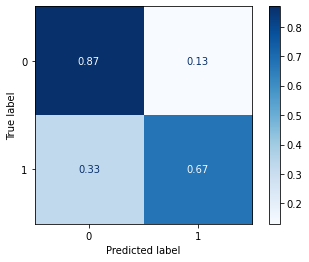

In [ ]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(gcv, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
print(disp.confusion_matrix)
plt.show()